##1. Imports and Drive mounting


In [ ]:
#imports and Drive mounting
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn as sk
import pandas as pd
from pandas import read_csv
from datetime import datetime
import math
import os

# fix random seed for reproducibility
seed = 2020
np.random.seed(seed)  

from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.losses import MAE
from google.colab import files

# uncomment if you want to use Drive

from google.colab import drive
drive.mount('/content/gdrive')


!ls '/content/gdrive/My Drive/'

2.4.1
Mounted at /content/gdrive
'Backups '	    'France roadtrip 2020.gmap'   presentations
'Beleggen '	     Git			 'Running tracks'
 Blockchain	     Letter.gdoc		  Scraping
 Brouwerij	     Limoncello			  Spark
'Colab Notebooks'   'Machine Learning '		 'The Unix Workbench'
 Dask		    'New Laptop'		  Travel
'Data engineering'   OOP			 'Web development'
 Education	     PhD
 Fietsen	     PowerBI


##2. Reading the data set


In [59]:
# load dataset

# this code only loads train and test datasets

# remember you also need to split off a validation dataset
# either by reusing and adapting the splitting code from the preprocessing notebook 
# or by writing your own code
# like in the previous assignments, this means you should have 4 sets:

# train_all (train+validate), train, validate and test

# The PATH setting below assumes you just uploaded the data file to your Colab session
# When using Drive: replace this by the path where you put the data file
DATAPATH = '/content/gdrive/My Drive/PhD/UGent courses/Deep Learning/Assignments/GA3/preprocessed_data/'
TRAINDATAFILE = DATAPATH+'preprocessed_train_data.csv'
VALDATAFILE = DATAPATH+'preprocessed_val_data.csv'
TESTDATAFILE = DATAPATH+'preprocessed_test_data.csv'

train_dataset = read_csv(TRAINDATAFILE, header=0, index_col=0)
val_dataset = read_csv(VALDATAFILE, header=0, index_col=0)
test_dataset = read_csv(TESTDATAFILE, header=0, index_col=0)

#check - note that you can make many other plots directly from pandas dataframes:
# https://pandas.pydata.org/pandas-docs/version/0.16/visualization.html

#train_dataset.plot(subplots=True,figsize=(16,26))

##3. Extract train, validate and test features and labels

In the code below, we will split of a validation set that is the same size as the test set (1 year) at the end of the training set.

In [61]:
print(train_dataset.columns)
print(len(train_dataset.columns))

Index(['pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain',
       'seasons_cos', 'seasons_sin', 'hour_cos', 'hour_sin', 'weekdays',
       'is_Friday', 'is_Monday', 'is_Saturday', 'is_Sunday', 'is_Thursday',
       'is_Tuesday', 'is_Wednesday', 'NE_strength', 'NW_strength',
       'NS_strength', 'cv_strength'],
      dtype='object')
23


In [62]:
# extract data from dataframes, selecting the features you want
# note that the labels simply contain the pollution data for now
# depending on the window sizes used in training, the correct values will be cut out

#using indexing, you can select which features you want to use (adapt to your needs)
# features = [4,5,6,7,11,12,13,14,15,16]
features = range(0,len(train_dataset.columns))

# index of the pollution data in the complete preprocessed feature set 
pollution = 0


# Important: Tensorflow 2.x gives an error if you omit
# the np.asarray(...,,dtype=np.float32)

# train and validate
train_values = np.asarray(train_dataset.values[:,features],dtype=np.float32)
train_labels = np.asarray(train_dataset.values[:,pollution],dtype=np.float32)
val_values = np.asarray(val_dataset.values[:,features],dtype=np.float32)
val_labels = np.asarray(val_dataset.values[:,pollution],dtype=np.float32)

# data for retraining before testing
train_all_values = np.concatenate((train_values,val_values))
train_all_labels = np.concatenate((train_labels,val_labels))

# test data
test_values = np.asarray(test_dataset.values[:,features],dtype=np.float32)
test_labels = np.asarray(test_dataset.values[:,pollution],dtype=np.float32)


# check
print(train_values.shape)
print(train_labels.shape)
print(val_values.shape)
print(val_labels.shape)

print(train_all_values.shape)
print(train_all_labels.shape)

print(test_values.shape)
print(test_labels.shape)


(26280, 23)
(26280,)
(8760, 23)
(8760,)
(35040, 23)
(35040,)
(8760, 23)
(8760,)


##4. Normalising the data

As you know by now, it is important to normalise the data. The flow is the following:

- initialise normaliser 1
- fit on training date
- use it to transform train and validation data

For your final model(s) you need a second normaliser:
- initialise normaliser 2
- fit on training+validation data
- use it to transform training+validation and test data

This has to be done **before** reformatting the data into windows (next section).  

Although we already did this before, the code below gives an example, The imports show that there are many different scalers. Especially with recurrent NNs, the choice of scaler can make a difference. Look up what each scaler does before choosing which one to try. Also, recurrent models may need different scalers than other models. Finally, you could also consider to start with a batchnorm layer to let your model fine-tune the feature scaling.


In [63]:
# imports to show that there are many different scalers
# especially with recurrent NNs, the choice of scaler can make a difference
# look up what they do before choosing which one to try

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

# Example: train standard scalers, apply to train and test data
# adapt to do all you need to do ...

SS1 = StandardScaler()
SS1.fit(train_values)

train_scaled = SS1.transform(train_values)
val_scaled = SS1.transform(val_values)

SS2 = StandardScaler()
SS2.fit(train_all_values)

train_all_scaled = SS2.transform(train_all_values)
test_scaled = SS2.transform(test_values)

##5. Transforming the data into the right format for model training

In the code below, helper functions are defined for the window-based model.

In [65]:
# window-based and recurrent networks:
# now, you use a window of k history values to predict
# this means that the features of the first k timesteps (indices 0 to k-1)
# are used to predict the k+3rd pollution value (index k+3-1)
# output dimension of train data is samples x window x features

def create_dataset_windowed(train, test, ahead=3, window_size=1):
  samples = train.shape[0]-ahead-(window_size-1) 
  dataX= []
  for i in range(samples):
      a = train[i:(i+window_size), :]
      dataX.append(a)
  return np.array(dataX), test[ahead+window_size-1:]

In [66]:
def PlotResults(labels,predictions,binsize = 10):
  num_samples = len(labels)
  
  fig = plt.figure(figsize=(16,16))
  spec = gridspec.GridSpec(ncols=4, nrows=4, figure=fig)
  ax1 = fig.add_subplot(spec[0, :])
  ax2 = fig.add_subplot(spec[1, :])
  ax3 = fig.add_subplot(spec[2:,0:2])
  ax4 = fig.add_subplot(spec[2:,2:])
  
  ax1.plot(labels,'k-',label='Labels')
  ax1.plot(predictions,'r-',label='Predictions')
  ax1.set_ylabel('Pollution')
  ax1.legend()
  
  errors=np.absolute(labels-predictions)
  ax2.plot(errors,'k-')
  ax2.set_ylabel("Absolute error")
  
  ax3.scatter(labels,predictions)
  ax3.set_xlabel('Labels')
  ax3.set_ylabel('Predictions')

  bins = np.arange(0,(np.ceil(np.max(errors)/binsize)+1)*binsize,binsize)
  
  ax4.hist(errors,bins=bins)
  ax4.set_xlabel('Absolute error')
  ax4.set_ylabel('Frequency')

  plt.show()


In [67]:
def plot_history(history):
  plt.figure(figsize = (6,4))
  
  plt.xlabel('Epoch')
  plt.ylabel('Mae')
  plt.plot(history.epoch, np.array(history.history['mae']),'g-',
           label='Train MAE')
  plt.plot(history.epoch, np.array(history.history['val_mae']),'r-',
           label = 'Validation MAE')
  plt.legend()
  plt.show()

##6. Building models


In [69]:
def my_Dense(num_features,learning_rate=0.001,hidden=[],ridge_param = 0.0,dropouts=[0.0]):
    # create linear modelmodel

    model = Sequential()
    model.add(Dropout(dropouts[0], input_shape=(num_features,)))
    for idx in range(len(hidden)):
      model.add(Dense(hidden[idx],activation = 'relu',kernel_regularizer=tf.keras.regularizers.l2(ridge_param)))
      model.add(Dropout(dropouts[idx+1]))
    model.add(Dense(1,activation='linear',kernel_regularizer=tf.keras.regularizers.l2(ridge_param)))
    
    optim = tf.keras.optimizers.Adam(lr=learning_rate)

    # Compile model
    # Note that Tensorflow allows you to directly optimise MAE during training!
    
    model.compile(loss='mae', optimizer=optim, metrics=['mae','mse']) # keep extra metrics: here mse and mae without regularisation terms
    return model  

The following code creates an overview of our best model architecture with different window sizes. The plots can be viewed as well. Our final model is chosen based on the best performing validation MAE.


 Model  1 / 17  with the following hyperparameters: 
 WINDOW_SIZE =  3 
 LEARNING_RATE =  0.001 
 HIDDEN =  [64, 32] 
 DROPOUTS =  [0, 0.25, 0.2] 
 RIDGE_PARAM =  0.001 
 BATCH_SIZE =  256 
 EPOCHS =  100 
 Best Early Stopping epoch =  16
"Dense Windowed" baseline:
 train mae =  25.89205 
 validation mae =  28.160809


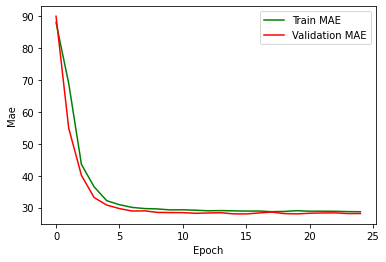

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_203 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_203 (Dense)            (None, 64)                256       
_________________________________________________________________
dropout_204 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_204 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_205 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_205 (Dense)            (None, 1)                 33        
Total params: 2,369
Trainable params: 2,369
Non-trainable params: 0
___________________________________________________

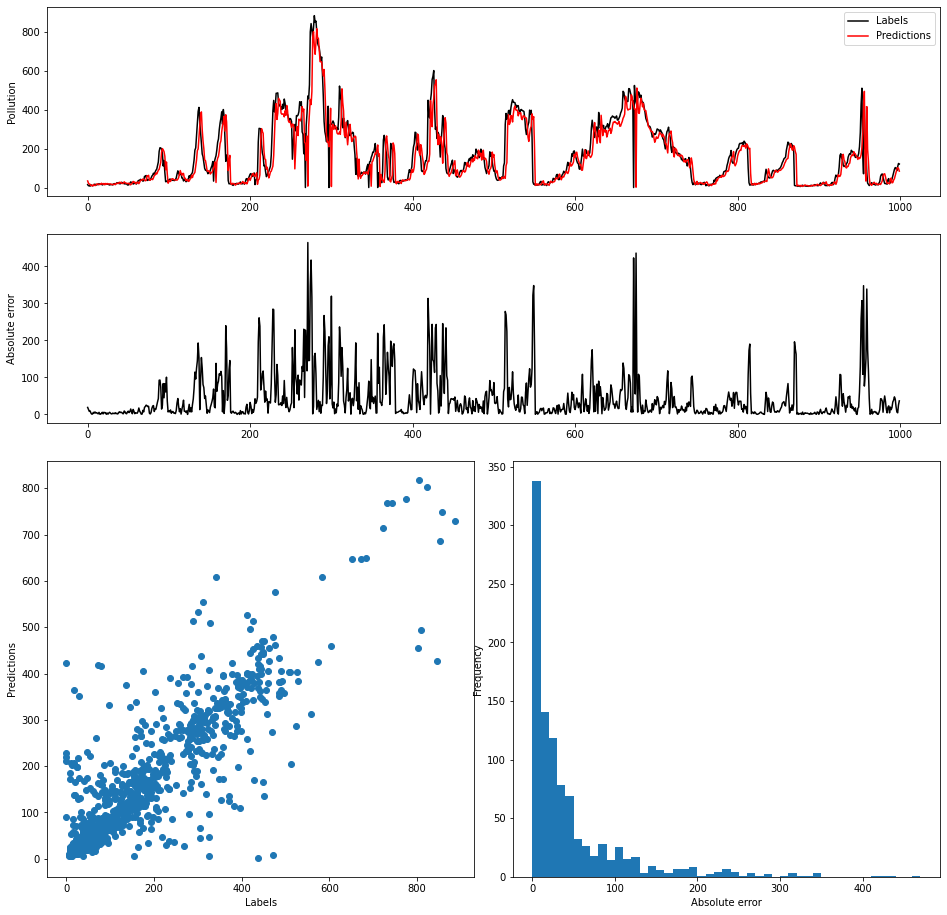

--------------------

 Model  2 / 17  with the following hyperparameters: 
 WINDOW_SIZE =  6 
 LEARNING_RATE =  0.001 
 HIDDEN =  [64, 32] 
 DROPOUTS =  [0, 0.25, 0.2] 
 RIDGE_PARAM =  0.001 
 BATCH_SIZE =  256 
 EPOCHS =  100 
 Best Early Stopping epoch =  21
"Dense Windowed" baseline:
 train mae =  25.870537 
 validation mae =  28.090483


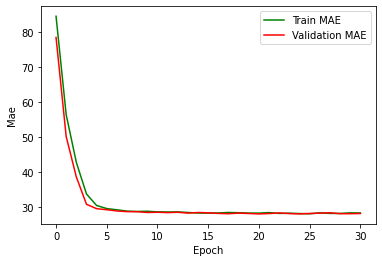

Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_206 (Dropout)        (None, 6)                 0         
_________________________________________________________________
dense_206 (Dense)            (None, 64)                448       
_________________________________________________________________
dropout_207 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_207 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_208 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_208 (Dense)            (None, 1)                 33        
Total params: 2,561
Trainable params: 2,561
Non-trainable params: 0
___________________________________________________

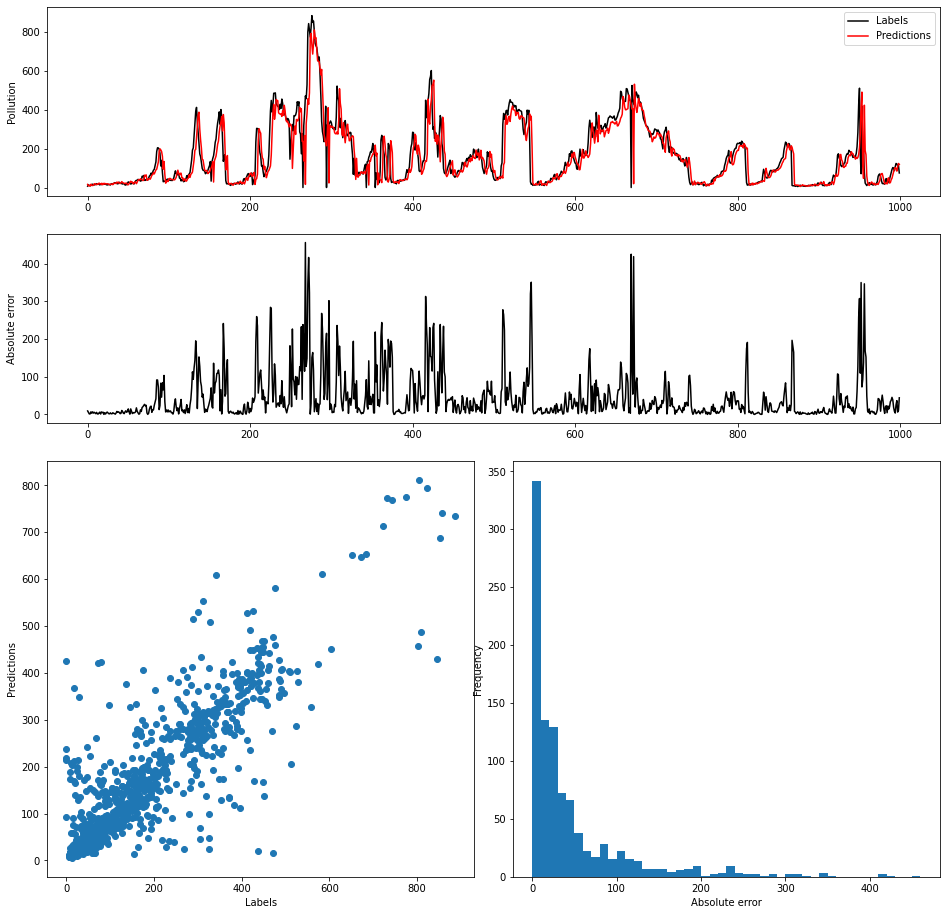

--------------------

 Model  3 / 17  with the following hyperparameters: 
 WINDOW_SIZE =  9 
 LEARNING_RATE =  0.001 
 HIDDEN =  [64, 32] 
 DROPOUTS =  [0, 0.25, 0.2] 
 RIDGE_PARAM =  0.001 
 BATCH_SIZE =  256 
 EPOCHS =  100 
 Best Early Stopping epoch =  24
"Dense Windowed" baseline:
 train mae =  25.956656 
 validation mae =  28.142546


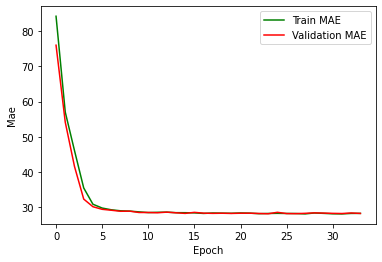

Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_209 (Dropout)        (None, 9)                 0         
_________________________________________________________________
dense_209 (Dense)            (None, 64)                640       
_________________________________________________________________
dropout_210 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_210 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_211 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_211 (Dense)            (None, 1)                 33        
Total params: 2,753
Trainable params: 2,753
Non-trainable params: 0
___________________________________________________

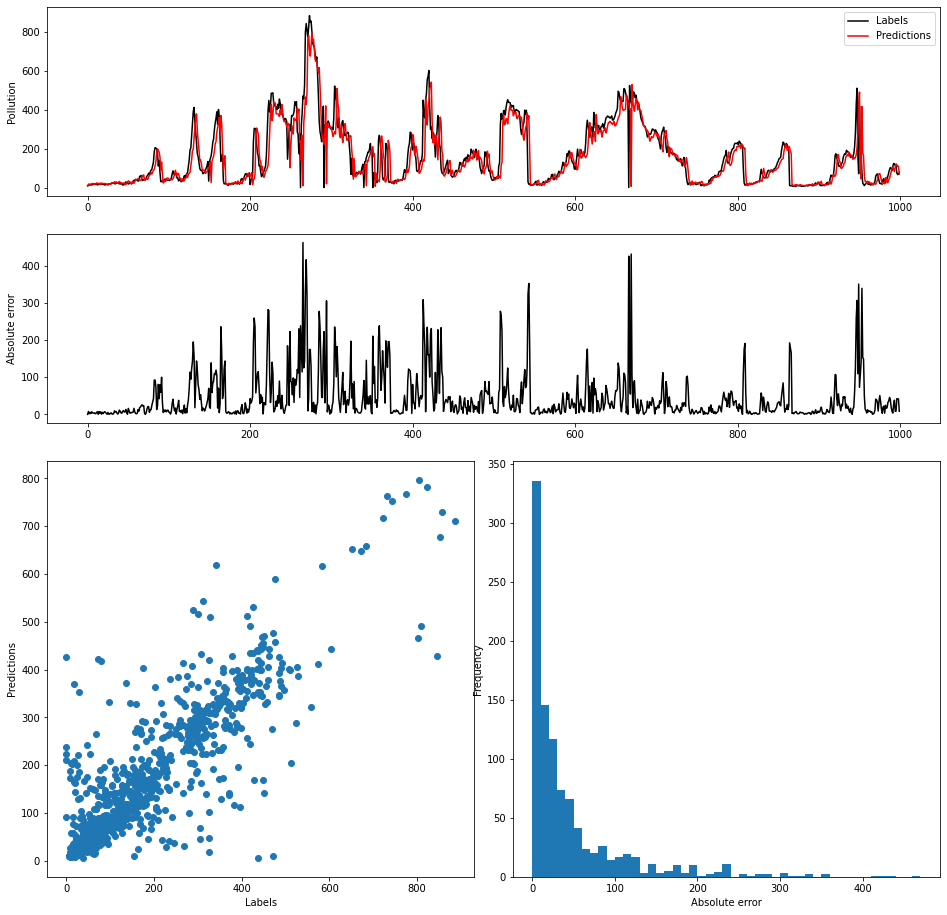

--------------------

 Model  4 / 17  with the following hyperparameters: 
 WINDOW_SIZE =  12 
 LEARNING_RATE =  0.001 
 HIDDEN =  [64, 32] 
 DROPOUTS =  [0, 0.25, 0.2] 
 RIDGE_PARAM =  0.001 
 BATCH_SIZE =  256 
 EPOCHS =  100 
 Best Early Stopping epoch =  27
"Dense Windowed" baseline:
 train mae =  25.925621 
 validation mae =  28.138655


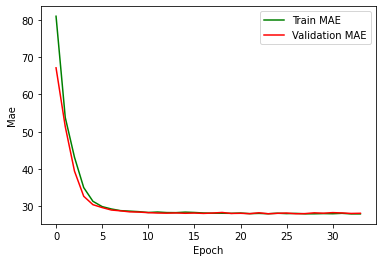

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_212 (Dropout)        (None, 12)                0         
_________________________________________________________________
dense_212 (Dense)            (None, 64)                832       
_________________________________________________________________
dropout_213 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_213 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_214 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_214 (Dense)            (None, 1)                 33        
Total params: 2,945
Trainable params: 2,945
Non-trainable params: 0
___________________________________________________

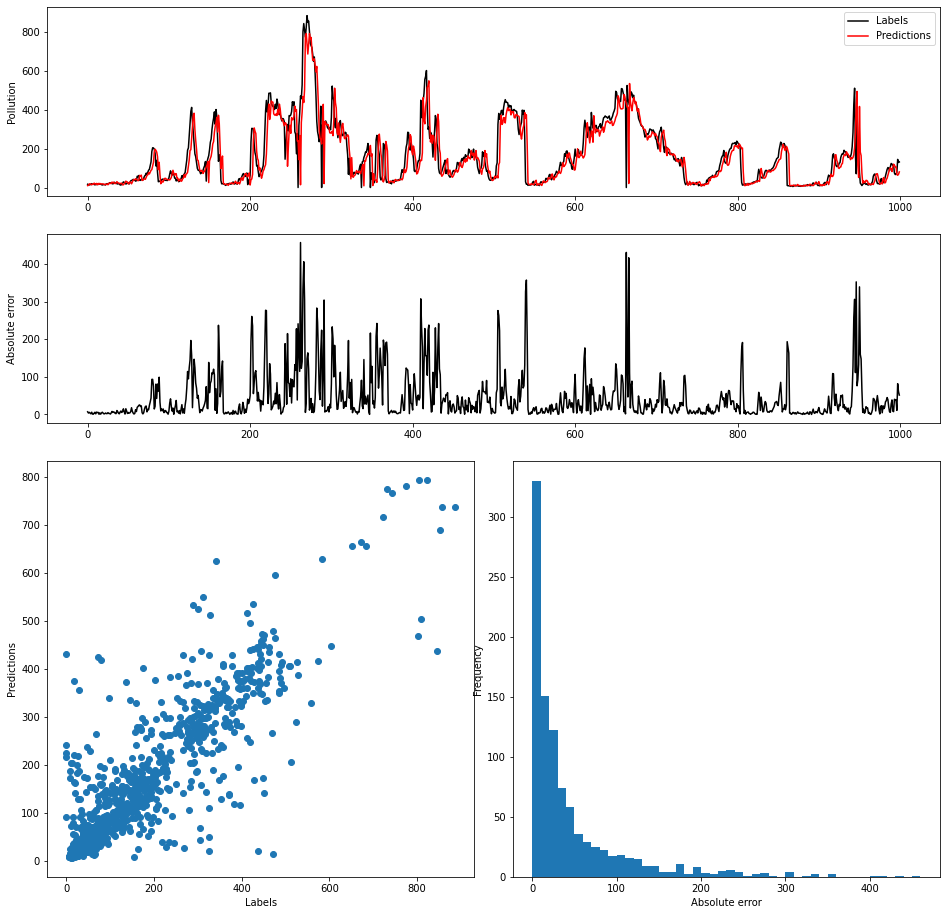

--------------------

 Model  5 / 17  with the following hyperparameters: 
 WINDOW_SIZE =  15 
 LEARNING_RATE =  0.001 
 HIDDEN =  [64, 32] 
 DROPOUTS =  [0, 0.25, 0.2] 
 RIDGE_PARAM =  0.001 
 BATCH_SIZE =  256 
 EPOCHS =  100 
 Best Early Stopping epoch =  45
"Dense Windowed" baseline:
 train mae =  25.99284 
 validation mae =  28.29223


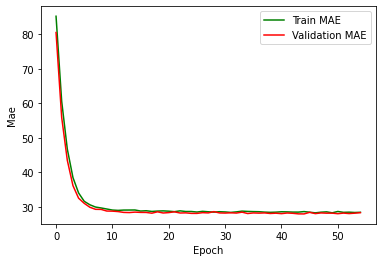

Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_215 (Dropout)        (None, 15)                0         
_________________________________________________________________
dense_215 (Dense)            (None, 64)                1024      
_________________________________________________________________
dropout_216 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_216 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_217 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_217 (Dense)            (None, 1)                 33        
Total params: 3,137
Trainable params: 3,137
Non-trainable params: 0
___________________________________________________

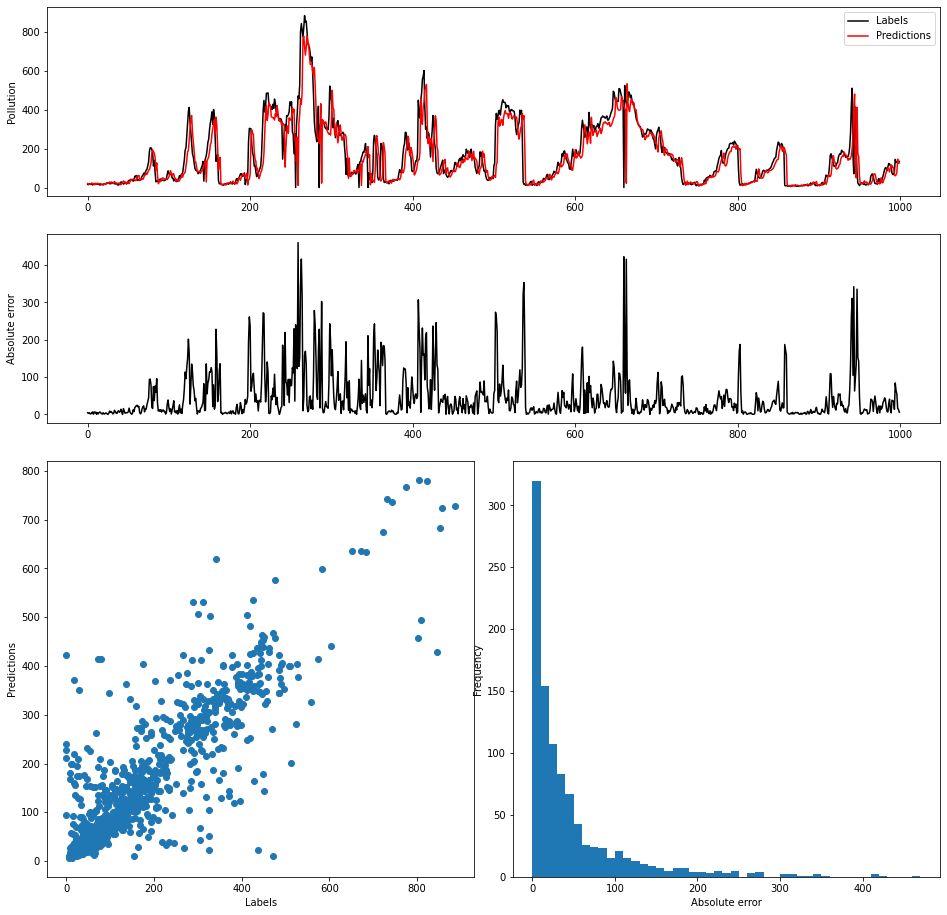

--------------------

 Model  6 / 17  with the following hyperparameters: 
 WINDOW_SIZE =  18 
 LEARNING_RATE =  0.001 
 HIDDEN =  [64, 32] 
 DROPOUTS =  [0, 0.25, 0.2] 
 RIDGE_PARAM =  0.001 
 BATCH_SIZE =  256 
 EPOCHS =  100 
 Best Early Stopping epoch =  28
"Dense Windowed" baseline:
 train mae =  25.975494 
 validation mae =  28.430365


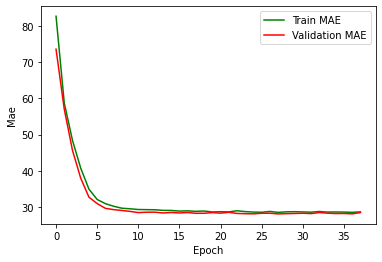

Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_218 (Dropout)        (None, 18)                0         
_________________________________________________________________
dense_218 (Dense)            (None, 64)                1216      
_________________________________________________________________
dropout_219 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_219 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_220 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_220 (Dense)            (None, 1)                 33        
Total params: 3,329
Trainable params: 3,329
Non-trainable params: 0
___________________________________________________

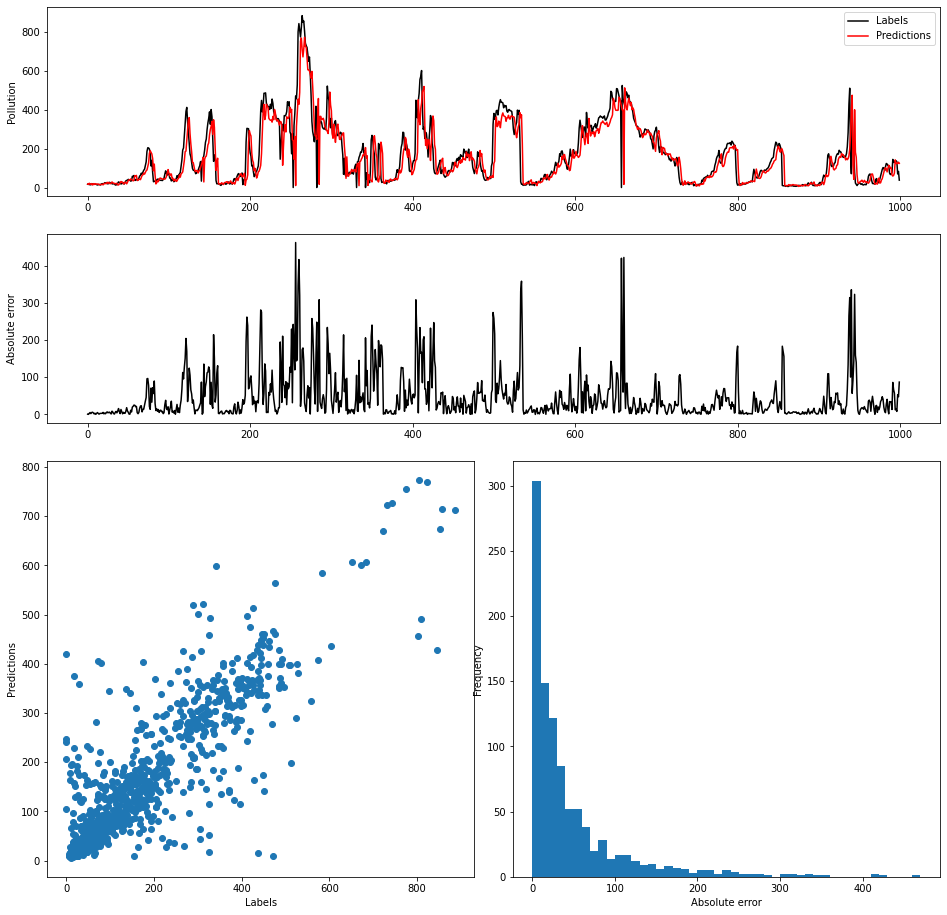

--------------------

 Model  7 / 17  with the following hyperparameters: 
 WINDOW_SIZE =  21 
 LEARNING_RATE =  0.001 
 HIDDEN =  [64, 32] 
 DROPOUTS =  [0, 0.25, 0.2] 
 RIDGE_PARAM =  0.001 
 BATCH_SIZE =  256 
 EPOCHS =  100 
 Best Early Stopping epoch =  28
"Dense Windowed" baseline:
 train mae =  25.835787 
 validation mae =  28.118748


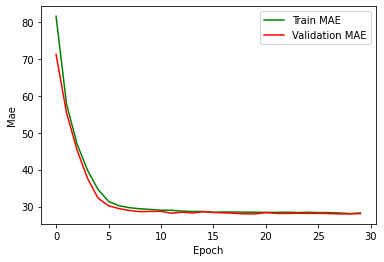

Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_221 (Dropout)        (None, 21)                0         
_________________________________________________________________
dense_221 (Dense)            (None, 64)                1408      
_________________________________________________________________
dropout_222 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_222 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_223 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_223 (Dense)            (None, 1)                 33        
Total params: 3,521
Trainable params: 3,521
Non-trainable params: 0
___________________________________________________

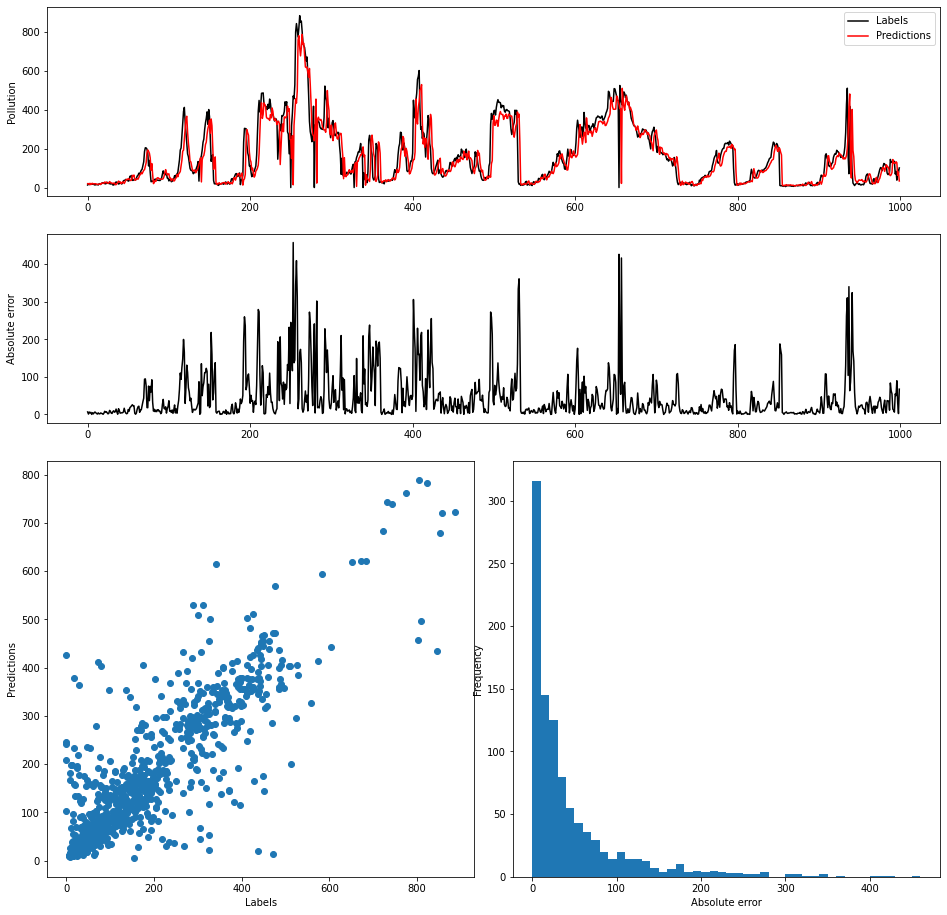

--------------------

 Model  8 / 17  with the following hyperparameters: 
 WINDOW_SIZE =  24 
 LEARNING_RATE =  0.001 
 HIDDEN =  [64, 32] 
 DROPOUTS =  [0, 0.25, 0.2] 
 RIDGE_PARAM =  0.001 
 BATCH_SIZE =  256 
 EPOCHS =  100 
 Best Early Stopping epoch =  38
"Dense Windowed" baseline:
 train mae =  25.874128 
 validation mae =  28.121065


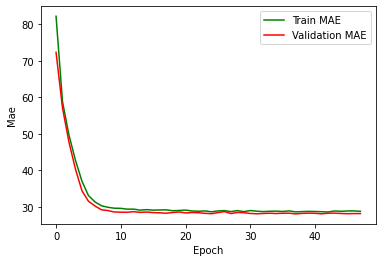

Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_224 (Dropout)        (None, 24)                0         
_________________________________________________________________
dense_224 (Dense)            (None, 64)                1600      
_________________________________________________________________
dropout_225 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_225 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_226 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_226 (Dense)            (None, 1)                 33        
Total params: 3,713
Trainable params: 3,713
Non-trainable params: 0
___________________________________________________

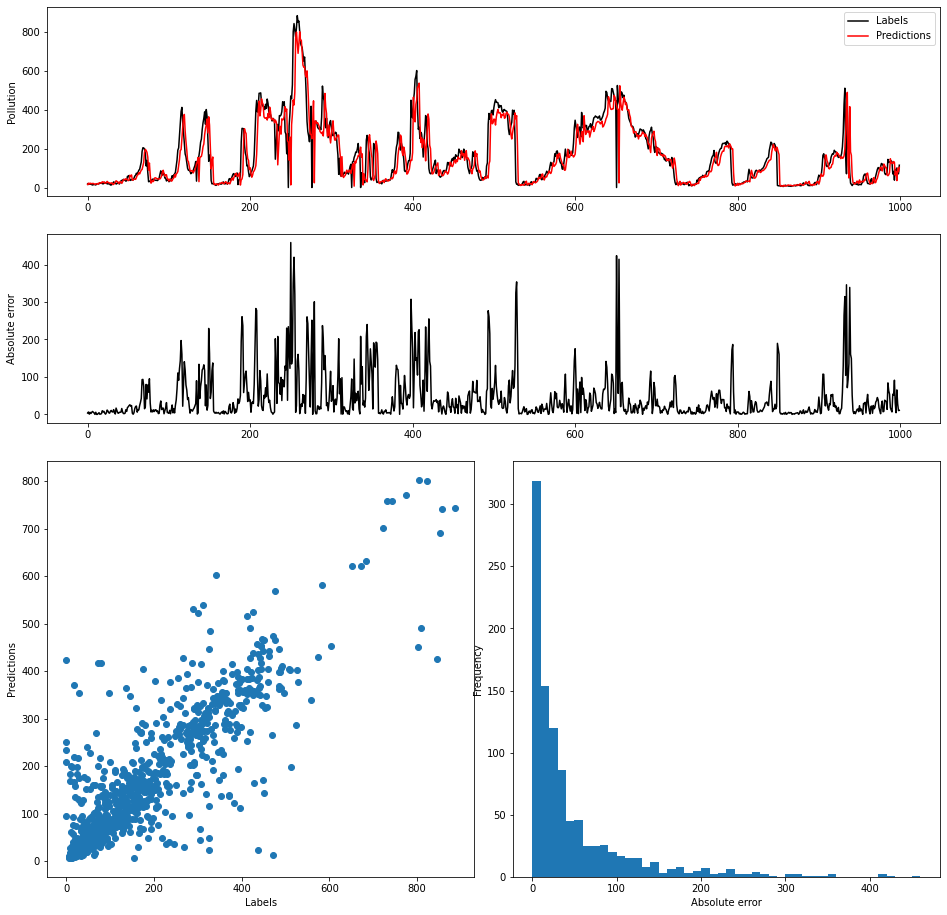

--------------------

 Model  9 / 17  with the following hyperparameters: 
 WINDOW_SIZE =  30 
 LEARNING_RATE =  0.001 
 HIDDEN =  [64, 32] 
 DROPOUTS =  [0, 0.25, 0.2] 
 RIDGE_PARAM =  0.001 
 BATCH_SIZE =  256 
 EPOCHS =  100 
 Best Early Stopping epoch =  27
"Dense Windowed" baseline:
 train mae =  25.706568 
 validation mae =  28.156738


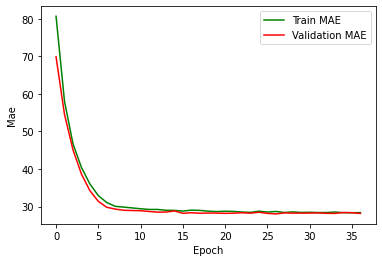

Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_227 (Dropout)        (None, 30)                0         
_________________________________________________________________
dense_227 (Dense)            (None, 64)                1984      
_________________________________________________________________
dropout_228 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_228 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_229 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_229 (Dense)            (None, 1)                 33        
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
___________________________________________________

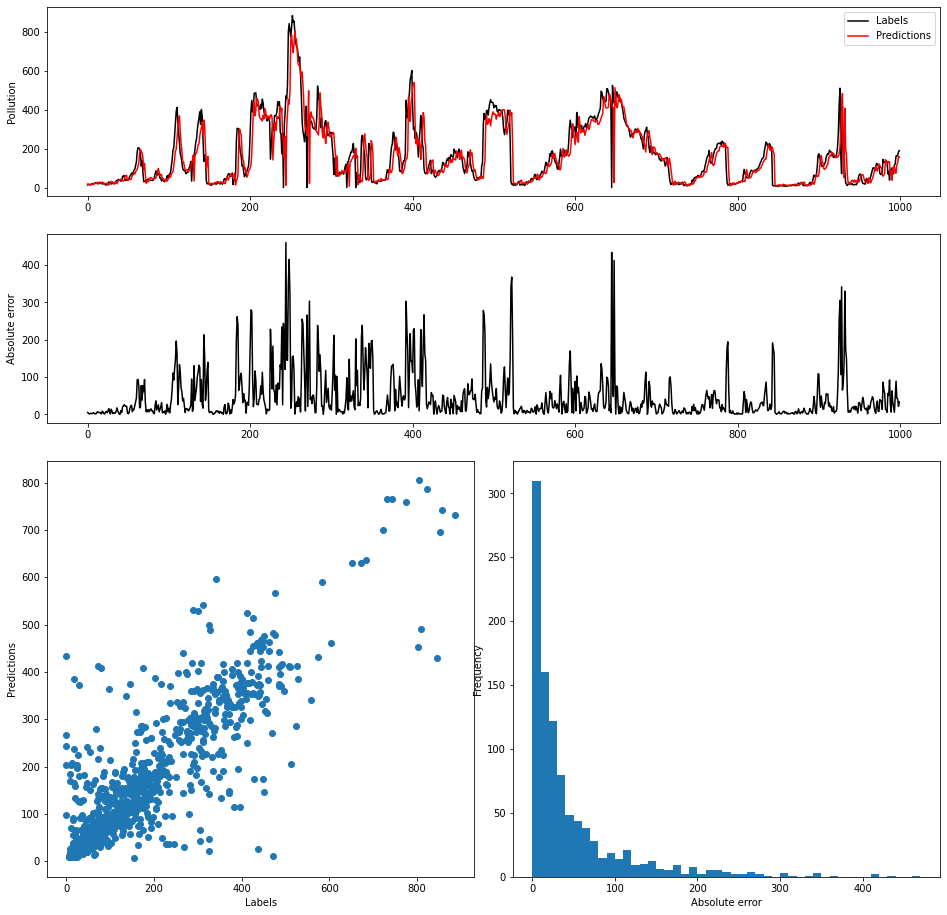

--------------------

 Model  10 / 17  with the following hyperparameters: 
 WINDOW_SIZE =  36 
 LEARNING_RATE =  0.001 
 HIDDEN =  [64, 32] 
 DROPOUTS =  [0, 0.25, 0.2] 
 RIDGE_PARAM =  0.001 
 BATCH_SIZE =  256 
 EPOCHS =  100 
 Best Early Stopping epoch =  28
"Dense Windowed" baseline:
 train mae =  25.931131 
 validation mae =  28.211151


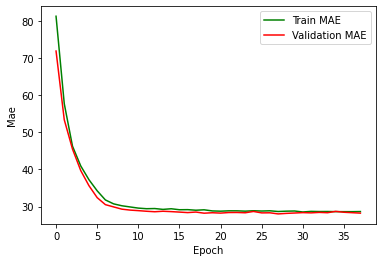

Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_230 (Dropout)        (None, 36)                0         
_________________________________________________________________
dense_230 (Dense)            (None, 64)                2368      
_________________________________________________________________
dropout_231 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_231 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_232 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_232 (Dense)            (None, 1)                 33        
Total params: 4,481
Trainable params: 4,481
Non-trainable params: 0
___________________________________________________

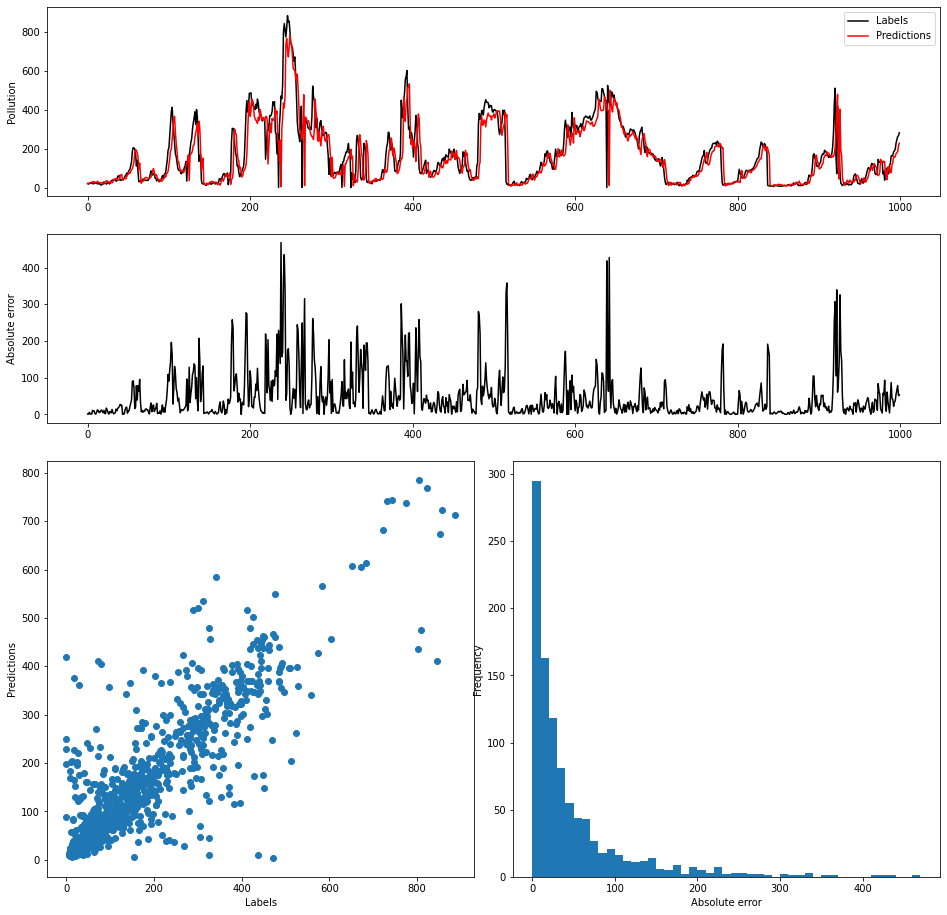

--------------------

 Model  11 / 17  with the following hyperparameters: 
 WINDOW_SIZE =  42 
 LEARNING_RATE =  0.001 
 HIDDEN =  [64, 32] 
 DROPOUTS =  [0, 0.25, 0.2] 
 RIDGE_PARAM =  0.001 
 BATCH_SIZE =  256 
 EPOCHS =  100 
 Best Early Stopping epoch =  28
"Dense Windowed" baseline:
 train mae =  25.69622 
 validation mae =  28.210026


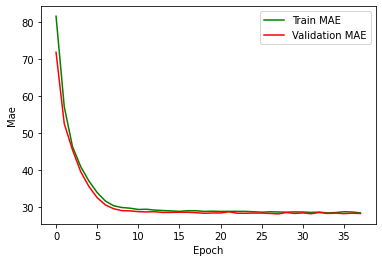

Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_233 (Dropout)        (None, 42)                0         
_________________________________________________________________
dense_233 (Dense)            (None, 64)                2752      
_________________________________________________________________
dropout_234 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_234 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_235 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_235 (Dense)            (None, 1)                 33        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
___________________________________________________

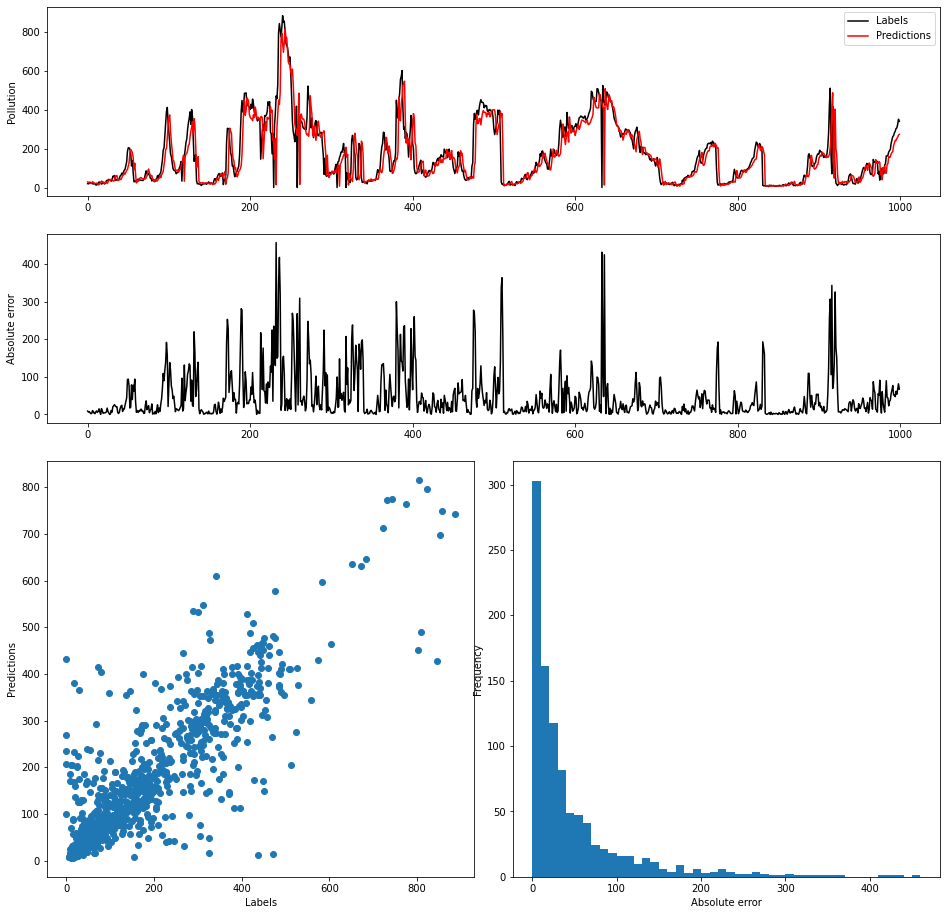

--------------------

 Model  12 / 17  with the following hyperparameters: 
 WINDOW_SIZE =  48 
 LEARNING_RATE =  0.001 
 HIDDEN =  [64, 32] 
 DROPOUTS =  [0, 0.25, 0.2] 
 RIDGE_PARAM =  0.001 
 BATCH_SIZE =  256 
 EPOCHS =  100 
 Best Early Stopping epoch =  57
"Dense Windowed" baseline:
 train mae =  25.559252 
 validation mae =  28.131193


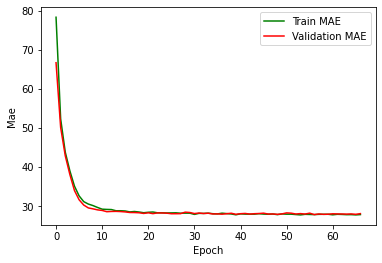

Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_236 (Dropout)        (None, 48)                0         
_________________________________________________________________
dense_236 (Dense)            (None, 64)                3136      
_________________________________________________________________
dropout_237 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_237 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_238 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_238 (Dense)            (None, 1)                 33        
Total params: 5,249
Trainable params: 5,249
Non-trainable params: 0
___________________________________________________

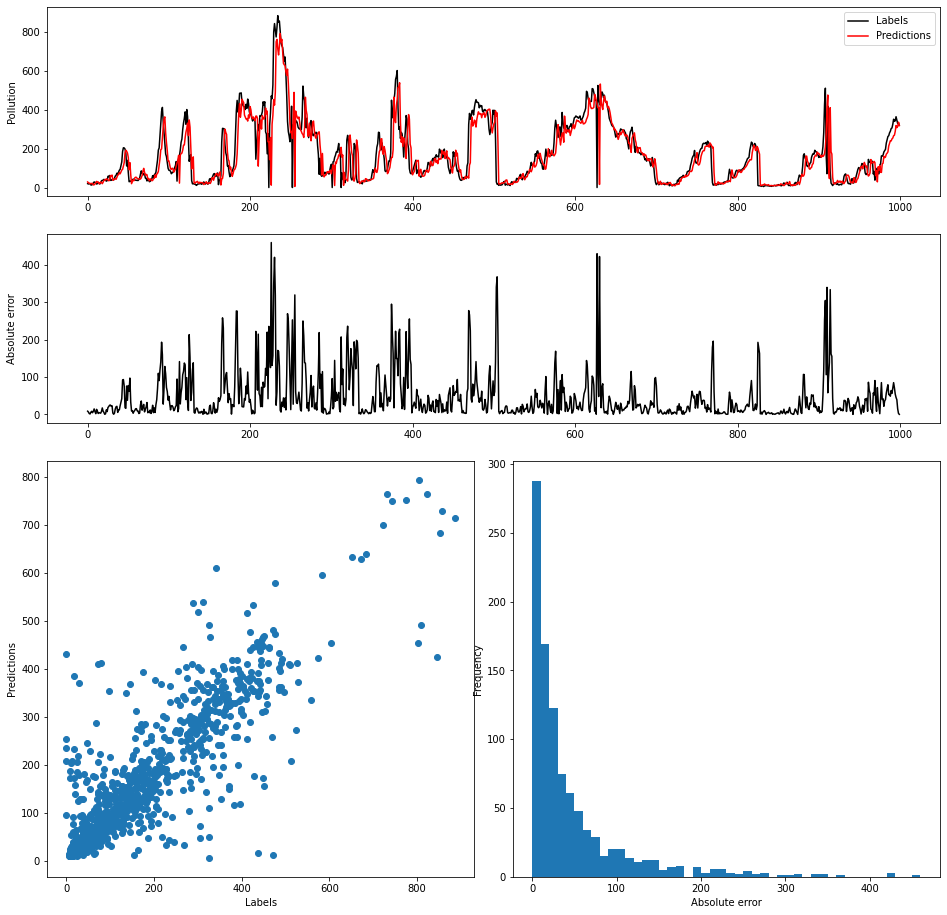

--------------------

 Model  13 / 17  with the following hyperparameters: 
 WINDOW_SIZE =  72 
 LEARNING_RATE =  0.001 
 HIDDEN =  [64, 32] 
 DROPOUTS =  [0, 0.25, 0.2] 
 RIDGE_PARAM =  0.001 
 BATCH_SIZE =  256 
 EPOCHS =  100 
 Best Early Stopping epoch =  44
"Dense Windowed" baseline:
 train mae =  25.601467 
 validation mae =  28.095747


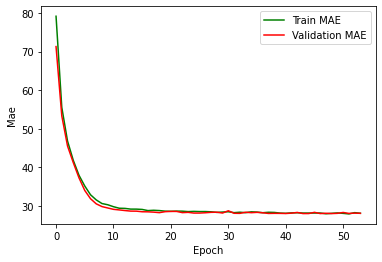

Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_239 (Dropout)        (None, 72)                0         
_________________________________________________________________
dense_239 (Dense)            (None, 64)                4672      
_________________________________________________________________
dropout_240 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_240 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_241 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_241 (Dense)            (None, 1)                 33        
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
___________________________________________________

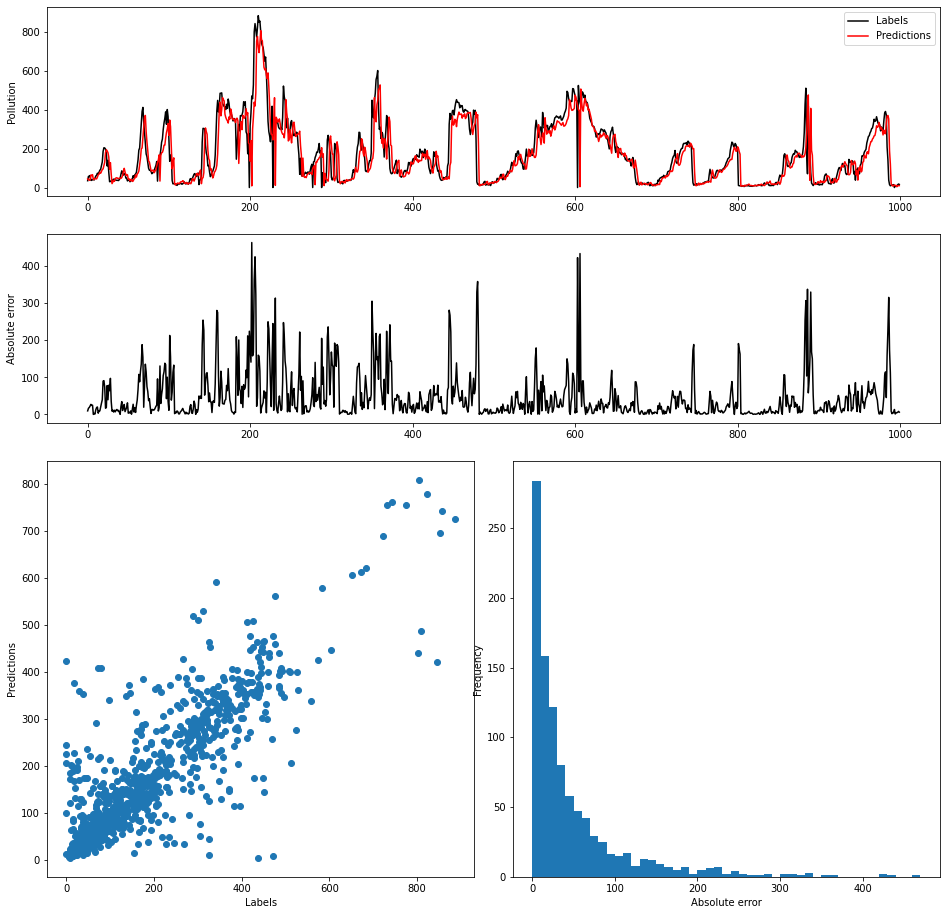

--------------------

 Model  14 / 17  with the following hyperparameters: 
 WINDOW_SIZE =  96 
 LEARNING_RATE =  0.001 
 HIDDEN =  [64, 32] 
 DROPOUTS =  [0, 0.25, 0.2] 
 RIDGE_PARAM =  0.001 
 BATCH_SIZE =  256 
 EPOCHS =  100 
 Best Early Stopping epoch =  29
"Dense Windowed" baseline:
 train mae =  25.574268 
 validation mae =  28.13993


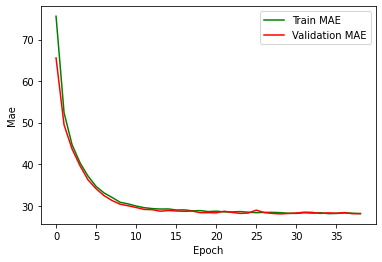

Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_242 (Dropout)        (None, 96)                0         
_________________________________________________________________
dense_242 (Dense)            (None, 64)                6208      
_________________________________________________________________
dropout_243 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_243 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_244 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_244 (Dense)            (None, 1)                 33        
Total params: 8,321
Trainable params: 8,321
Non-trainable params: 0
___________________________________________________

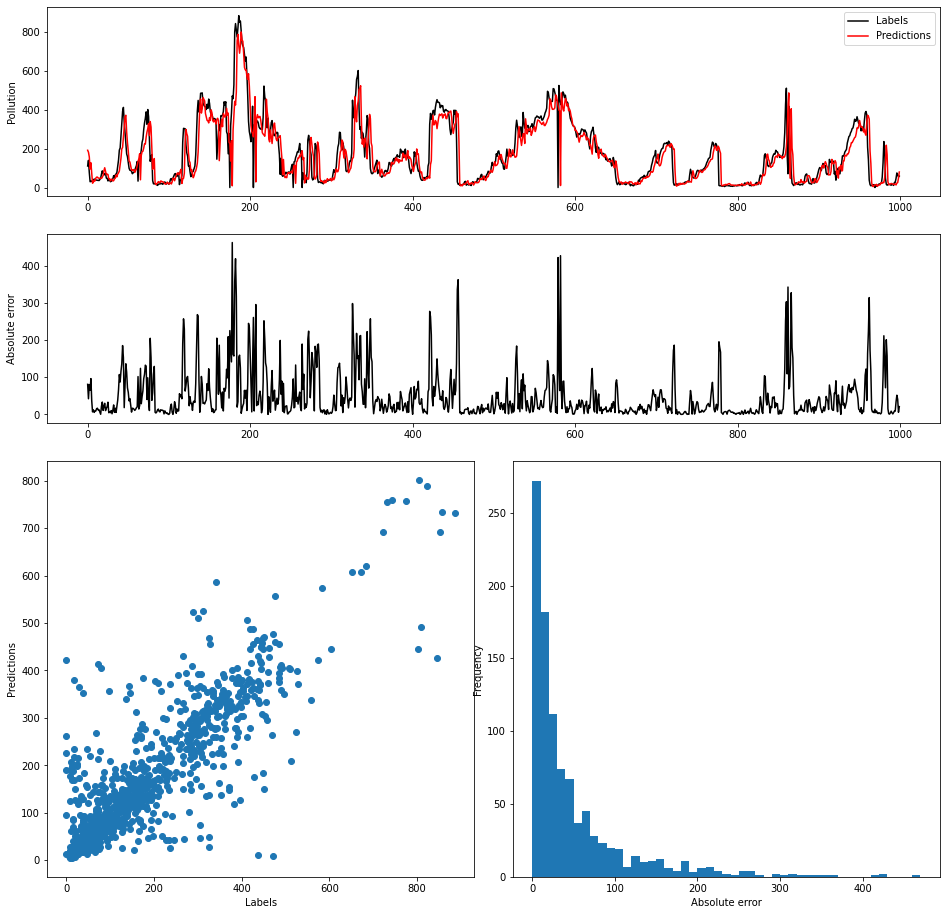

--------------------

 Model  15 / 17  with the following hyperparameters: 
 WINDOW_SIZE =  120 
 LEARNING_RATE =  0.001 
 HIDDEN =  [64, 32] 
 DROPOUTS =  [0, 0.25, 0.2] 
 RIDGE_PARAM =  0.001 
 BATCH_SIZE =  256 
 EPOCHS =  100 
 Best Early Stopping epoch =  33
"Dense Windowed" baseline:
 train mae =  25.610645 
 validation mae =  28.349384


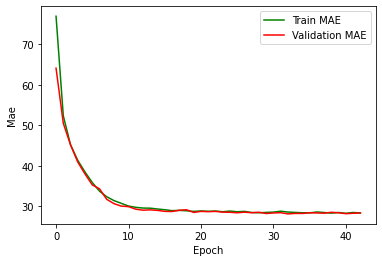

Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_245 (Dropout)        (None, 120)               0         
_________________________________________________________________
dense_245 (Dense)            (None, 64)                7744      
_________________________________________________________________
dropout_246 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_246 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_247 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_247 (Dense)            (None, 1)                 33        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
___________________________________________________

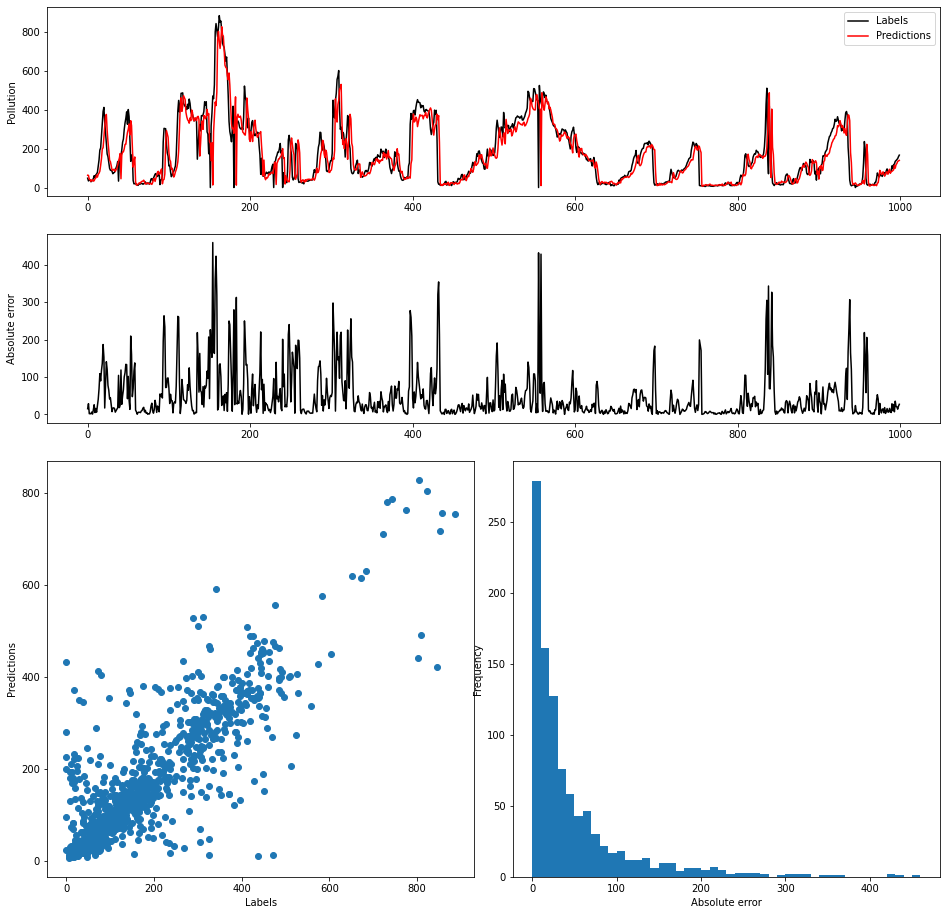

--------------------

 Model  16 / 17  with the following hyperparameters: 
 WINDOW_SIZE =  144 
 LEARNING_RATE =  0.001 
 HIDDEN =  [64, 32] 
 DROPOUTS =  [0, 0.25, 0.2] 
 RIDGE_PARAM =  0.001 
 BATCH_SIZE =  256 
 EPOCHS =  100 
 Best Early Stopping epoch =  37
"Dense Windowed" baseline:
 train mae =  25.523901 
 validation mae =  28.343966


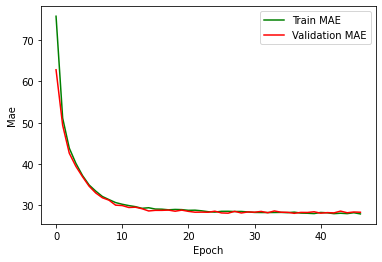

Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_248 (Dropout)        (None, 144)               0         
_________________________________________________________________
dense_248 (Dense)            (None, 64)                9280      
_________________________________________________________________
dropout_249 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_249 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_250 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_250 (Dense)            (None, 1)                 33        
Total params: 11,393
Trainable params: 11,393
Non-trainable params: 0
_________________________________________________

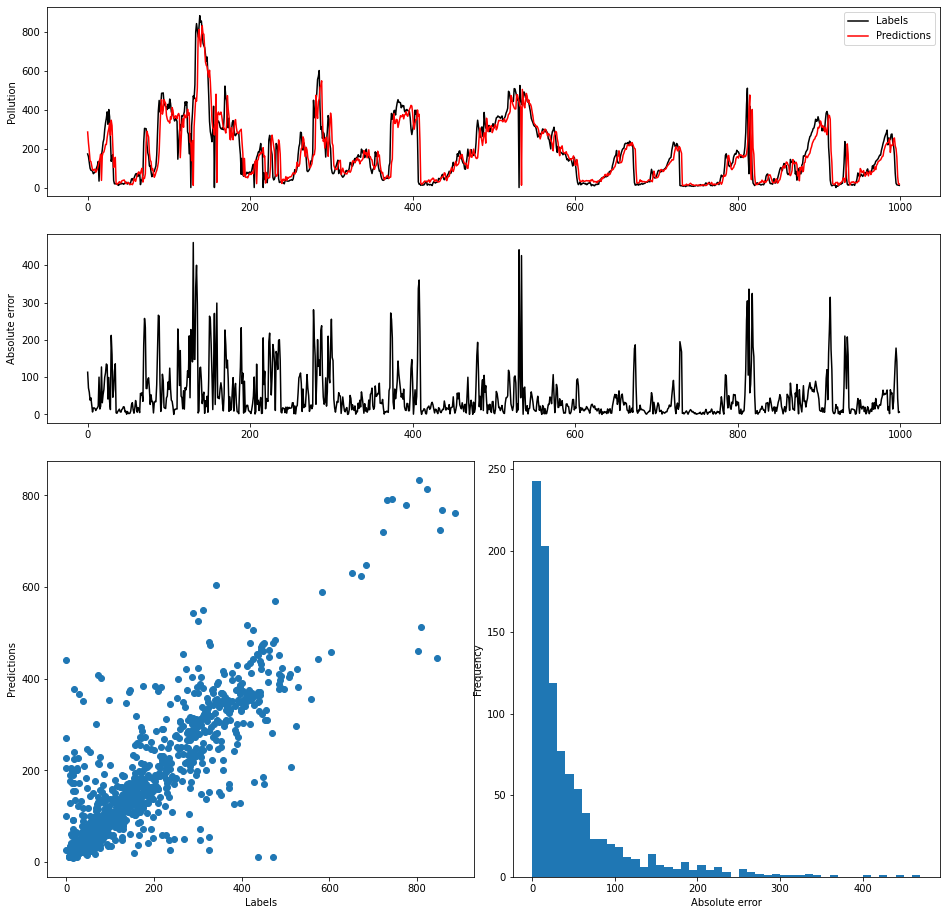

--------------------

 Model  17 / 17  with the following hyperparameters: 
 WINDOW_SIZE =  168 
 LEARNING_RATE =  0.001 
 HIDDEN =  [64, 32] 
 DROPOUTS =  [0, 0.25, 0.2] 
 RIDGE_PARAM =  0.001 
 BATCH_SIZE =  256 
 EPOCHS =  100 
 Best Early Stopping epoch =  35
"Dense Windowed" baseline:
 train mae =  25.49189 
 validation mae =  28.475134


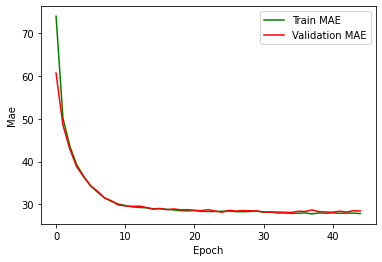

Model: "sequential_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_251 (Dropout)        (None, 168)               0         
_________________________________________________________________
dense_251 (Dense)            (None, 64)                10816     
_________________________________________________________________
dropout_252 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_252 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_253 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_253 (Dense)            (None, 1)                 33        
Total params: 12,929
Trainable params: 12,929
Non-trainable params: 0
_________________________________________________

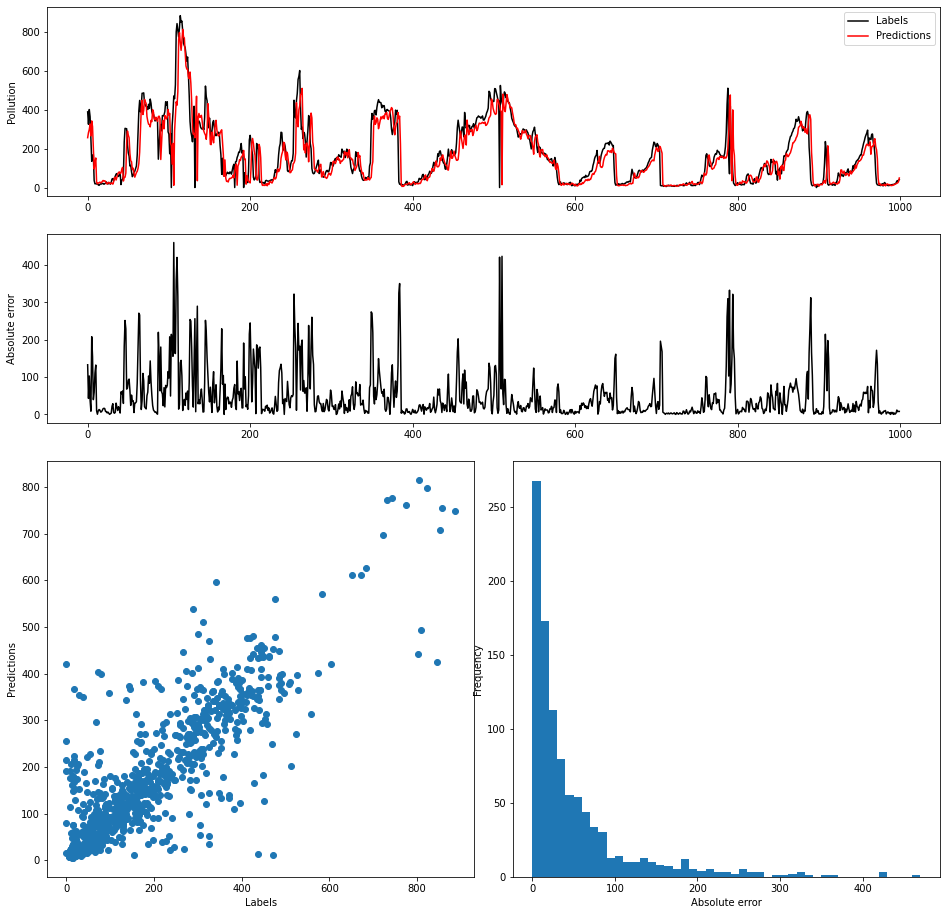

--------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [70]:
#Columns of interest for our final dataframe
columns = ['Model number', 'Window Size', 'Learning rate', 'Hidden layers', 'Dropout', 'L2', 'Batch size', 'Epochs', 'Train MAE', 'Val MAE', 'Gap TrainVal MAE', 'Early stopping epoch']

#Create empty dataframe in which all the info will be stored
results = pd.DataFrame(columns=columns)

WINDOW_SIZE_list = [3, 6, 9, 12, 15, 18, 21, 24, 30, 36, 42, 48, 72, 96, 120, 144, 168]
LEARNING_RATE_list = [0.001]
HIDDEN_list = [[64, 32]]
DROPOUTS_list = [[0, 0.25, 0.2]]
RIDGE_PARAM_list = [1e-3]
BATCH_SIZE_list = [256]
EPOCHS_list = [100]

total_models = len(WINDOW_SIZE_list) * len(LEARNING_RATE_list) * len(HIDDEN_list) * len(DROPOUTS_list) * len(RIDGE_PARAM_list) * len(BATCH_SIZE_list) * len(EPOCHS_list)
model_number = 1

# current code for pollution-only, add other features for multi-feature model, 
# remove indices as in commented code if you want to use all features
# note that in the current feature set, pollution is the first feature (index=0)

train_features = [0,] 
for EPOCHS in EPOCHS_list:
  for WINDOW_SIZE in WINDOW_SIZE_list:
    for HIDDEN in HIDDEN_list:
      for DROPOUTS in DROPOUTS_list:
        for RIDGE_PARAM in RIDGE_PARAM_list:
          for BATCH_SIZE in BATCH_SIZE_list:
            for LEARNING_RATE in LEARNING_RATE_list:
              X_train_w,r_train_w = create_dataset_windowed(train_scaled[:,train_features],train_labels, window_size=WINDOW_SIZE)
              X_val_w,r_val_w = create_dataset_windowed(val_scaled[:,train_features],val_labels, window_size=WINDOW_SIZE)

              X_train_all_w,r_train_all_w = create_dataset_windowed(train_all_scaled[:,train_features],train_all_labels, window_size=WINDOW_SIZE)
              X_test_w,r_test_w = create_dataset_windowed(test_scaled[:,train_features],test_labels, window_size=WINDOW_SIZE)

              DenseWindowedModel = my_Dense(WINDOW_SIZE, learning_rate=LEARNING_RATE, hidden=HIDDEN, dropouts=DROPOUTS, ridge_param=RIDGE_PARAM)

              stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=10, min_delta=0.01)

              DW_history = DenseWindowedModel.fit(X_train_w, r_train_w,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        verbose=0,
                        validation_data=(X_val_w, r_val_w),
                        callbacks = [stopping_callback],
                        shuffle=True)
              
              best_early_stopping_epoch = np.argmin(DW_history.history['val_mae'])+1

              y_train_DWmodel = DenseWindowedModel.predict(X_train_w)
              y_val_DWmodel = DenseWindowedModel.predict(X_val_w)

              mae_train_DWmodel = mean_absolute_error(r_train_w,y_train_DWmodel)
              mae_val_DWmodel = mean_absolute_error(r_val_w,y_val_DWmodel)
              gap_train_val = round(mae_train_DWmodel-mae_val_DWmodel, 4)

              result_list = [[model_number, WINDOW_SIZE, LEARNING_RATE, HIDDEN, DROPOUTS, RIDGE_PARAM, BATCH_SIZE, EPOCHS, 
                              mae_train_DWmodel, mae_val_DWmodel, gap_train_val, best_early_stopping_epoch]]
              results = results.append(pd.DataFrame(result_list, columns = columns), ignore_index=True)

              print("\n Model ",model_number,"/",total_models, " with the following hyperparameters: \n WINDOW_SIZE = ", WINDOW_SIZE,
                    "\n LEARNING_RATE = ",LEARNING_RATE, "\n HIDDEN = ",HIDDEN,
                    "\n DROPOUTS = ",DROPOUTS, "\n RIDGE_PARAM = ",RIDGE_PARAM, 
                    "\n BATCH_SIZE = ",BATCH_SIZE, "\n EPOCHS = ",EPOCHS,
                    "\n Best Early Stopping epoch = ",best_early_stopping_epoch)

              print("\"Dense Windowed\" baseline:\n train mae = ",mae_train_DWmodel, "\n validation mae = ",mae_val_DWmodel)
              plot_history(DW_history)
              DenseWindowedModel.summary()
              # Visualise first 1000 predictions for validation
              PlotResults(r_val_w[:1000],y_val_DWmodel[:1000,0])
              print("-"*20)

              model_number += 1

results = results.sort_values(by=['Val MAE', 'Gap TrainVal MAE'], ascending=[True, False])

RESULTSDATAFILE = DATAPATH+'results_window_model_h64_32_windowsize_overview.csv'
results.to_csv(path_or_buf=RESULTSDATAFILE)
files.download(RESULTSDATAFILE)

In [71]:
results.head(20)

,Model number,Window Size,Learning rate,Hidden layers,Dropout,L2,Batch size,Epochs,Train MAE,Val MAE,Gap TrainVal MAE,Early stopping epoch
1,2,6,0.001,"[64, 32]","[0, 0.25, 0.2]",0.001,256,100,25.870537,28.090483,-2.2199,21
12,13,72,0.001,"[64, 32]","[0, 0.25, 0.2]",0.001,256,100,25.601467,28.095747,-2.4943,44
6,7,21,0.001,"[64, 32]","[0, 0.25, 0.2]",0.001,256,100,25.835787,28.118748,-2.2830,28
7,8,24,0.001,"[64, 32]","[0, 0.25, 0.2]",0.001,256,100,25.874128,28.121065,-2.2469,38
11,12,48,0.001,"[64, 32]","[0, 0.25, 0.2]",0.001,256,100,25.559252,28.131193,-2.5719,57
3,4,12,0.001,"[64, 32]","[0, 0.25, 0.2]",0.001,256,100,25.925621,28.138655,-2.2130,27
13,14,96,0.001,"[64, 32]","[0, 0.25, 0.2]",0.001,256,100,25.574268,28.139931,-2.5657,29
2,3,9,0.001,"[64, 32]","[0, 0.25, 0.2]",0.001,256,100,25.956656,28.142546,-2.1859,24
8,9,30,0.001,"[64, 32]","[0, 0.25, 0.2]",0.001,256,100,25.706568,28.156738,-2.4502,27
0,1,3,0.001,"[64, 32]","[0, 0.25, 0.2]",0.001,256,100,25.892050,28.160809,-2.2688,16


##7. Train best model on full training set and evaluate performance on the test set

In [73]:
WINDOW_SIZE = 6
X_train_all_w,r_train_all_w = create_dataset_windowed(train_all_scaled[:,train_features],train_all_labels, window_size=WINDOW_SIZE)
X_test_w,r_test_w = create_dataset_windowed(test_scaled[:,train_features],test_labels, window_size=WINDOW_SIZE)

DenseWindowedModel = my_Dense(WINDOW_SIZE, learning_rate=LEARNING_RATE, hidden=HIDDEN, dropouts=DROPOUTS, ridge_param=RIDGE_PARAM)
DW_history_final_model = DenseWindowedModel.fit(X_train_all_w, r_train_all_w,
                                                batch_size=BATCH_SIZE,
                                                epochs=21,
                                                verbose=0,
                                                shuffle=True)

In [75]:
y_train_all_DWmodel = DenseWindowedModel.predict(X_train_all_w)
y_test_DWmodel = DenseWindowedModel.predict(X_test_w)

mae_train_all_DWmodel = mean_absolute_error(r_train_all_w,y_train_all_DWmodel)
mae_test_DWmodel = mean_absolute_error(r_test_w,y_test_DWmodel)

print("\"Dense Windowed\" baseline:\n train all mae = ",mae_train_all_DWmodel, "\n test mae = ",mae_test_DWmodel)

"Dense Windowed" baseline:
 train all mae =  26.500402 
 test mae =  25.51374


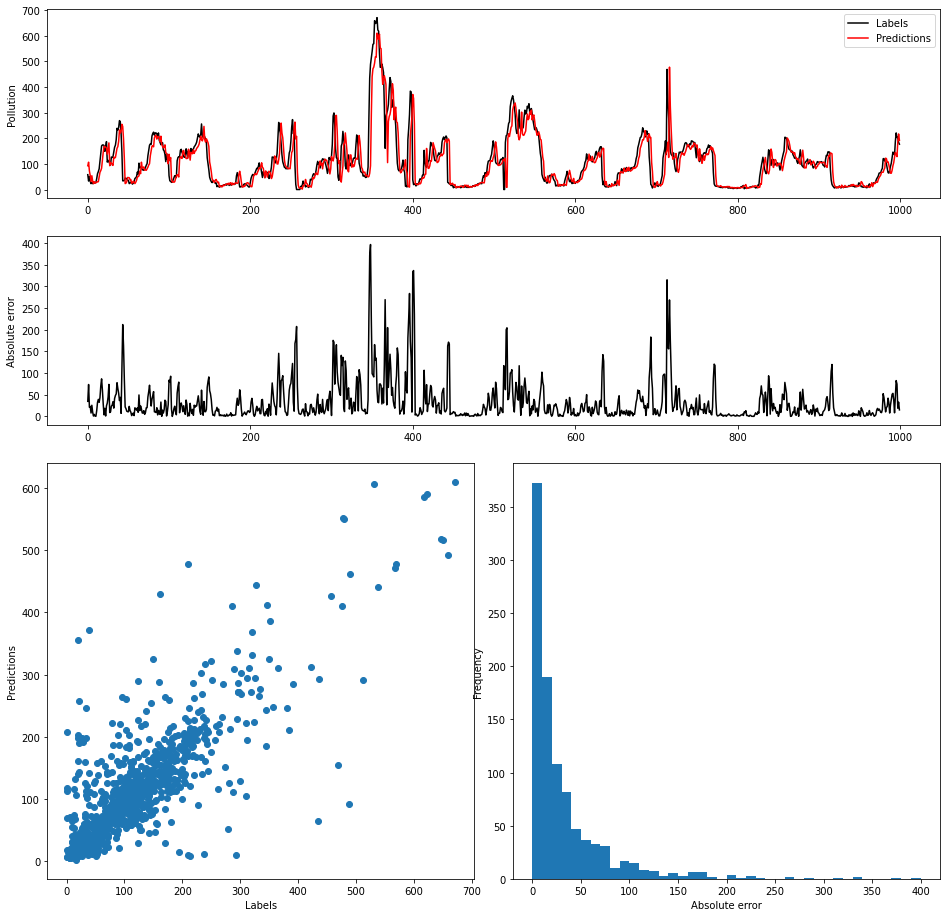

In [76]:
PlotResults(r_test_w[:1000],y_test_DWmodel[:1000,0])